In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
import json
import requests
import pandas as pd
import numpy as np
import tqdm
import warnings
import csv

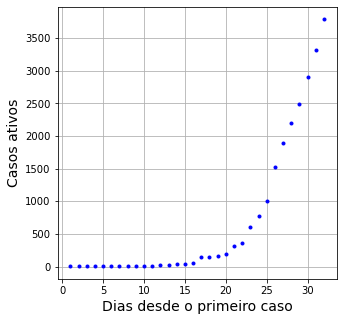

In [14]:
df = pd.read_csv('./covid19.csv', header=None)

x = df[0].to_numpy()
y = df[1].to_numpy()

X =  x.reshape(len(y), 1)
y =  y.reshape(len(y), 1)

fig = plt.figure(figsize=(5,5))
plt.plot(x, y, 'b.')
plt.xlabel('Dias desde o primeiro caso',  fontsize=14)
plt.ylabel('Casos ativos',  fontsize=14)
plt.grid()
plt.show()

# Holdout cross-validation (test size=0.1, 0.2, 0.3)

In [15]:
include_bias = False

numOfSeeds = 10

maxOrder = 12

testSize = [0.1, 0.2, 0.3]

mse_val_vec = np.zeros((len(testSize), maxOrder))
mse_train_vec = np.zeros((len(testSize), maxOrder))

for t in range(0, len(testSize)):

    for d in range(1, maxOrder+1):
        # Instantiate a polynomial.
        poly = PolynomialFeatures(degree=d, include_bias=include_bias)
        # Instantiate a scaler.
        scaler = StandardScaler()
        # Instantiate a linear regressor.
        reg = LinearRegression()

        # Create a pipeline of actions.
        poly_reg = Pipeline([
            ("poly", poly),
            ("scaler", scaler),
            ("reg", reg),
        ])

        mse_val = np.zeros((numOfSeeds,))
        mse_train = np.zeros((numOfSeeds,))
        for s in range(0, numOfSeeds):

            # Split the whole set into random training and validation set.
            x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=testSize[t], random_state=s)
            
            poly_reg.fit(x_train, y_train)

            y_val_predict = poly_reg.predict(x_val)

            y_train_predict = poly_reg.predict(x_train)

            mse_val[s] = mean_squared_error(y_val, y_val_predict)

            mse_train[s] = mean_squared_error(y_train, y_train_predict)

        mse_val_vec[t][d-1] = np.mean(mse_val)
        mse_train_vec[t][d-1] = np.mean(mse_train)

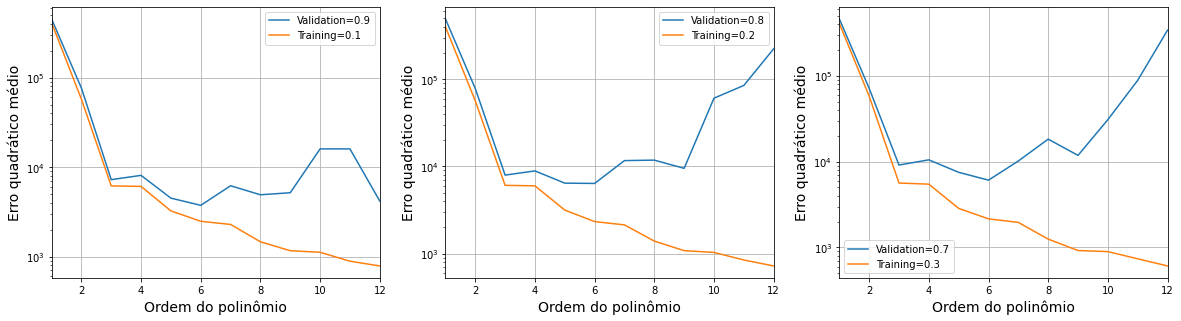

In [16]:
# Plot results.
plt.figure(figsize=(20, 5))

for t in range(0, len(testSize)): 
    
    ax = plt.subplot(1, len(testSize), t + 1)

    plt.plot(range(1, maxOrder+1), mse_val_vec[t],  label='Validation='+str(1-testSize[t]))
    plt.plot(range(1, maxOrder+1), mse_train_vec[t],  label='Training='+str(testSize[t]))
    plt.xlabel('Ordem do polinômio', fontsize=14)
    plt.ylabel('Erro quadrático médio', fontsize=14)
    plt.xticks(range(0, maxOrder+1, 2))
    plt.xlim([1, 12])
    plt.legend()
    plt.grid()
    plt.yscale('log')

# Save figure
#plt.savefig("holdout.png", dpi=600)
#Show the plot.
plt.show()

# k-fold cross-validation (k=2, 5, 10)

In [17]:
numOfSeeds = 10

maxOrder = 12

kSize = [2, 5, 10]

mse_val_vec = np.zeros((len(kSize), maxOrder))
std_val_vec = np.zeros((len(kSize), maxOrder))

for k in range(0, len(kSize)):

    for d in range(1, maxOrder+1):
        # Instantiate a polynomial.
        poly = PolynomialFeatures(degree=d, include_bias=include_bias)
        # Instantiate a scaler.
        scaler = StandardScaler()
        # Instantiate a linear regressor.
        reg = LinearRegression()

        # Create a pipeline of actions.
        poly_reg = Pipeline([
            ("poly", poly),
            ("scaler", scaler),
            ("reg", reg),
        ])

        mse_vec = np.zeros((numOfSeeds,))
        std_vec = np.zeros((numOfSeeds,))
        for s in range(0, numOfSeeds):

            # Instantiate the k-Fold object.
            kfold = KFold(n_splits=kSize[k], shuffle=True, random_state=s)
                        
            lin_scores = cross_val_score(poly_reg, X, y, scoring='neg_mean_squared_error', cv=kfold)

            scores = -lin_scores
            mse_vec[s] = scores.mean()
            std_vec[s] = scores.std()
            
        mse_val_vec[k][d-1] = np.mean(mse_vec)
        std_val_vec[k][d-1] = np.mean(std_vec)

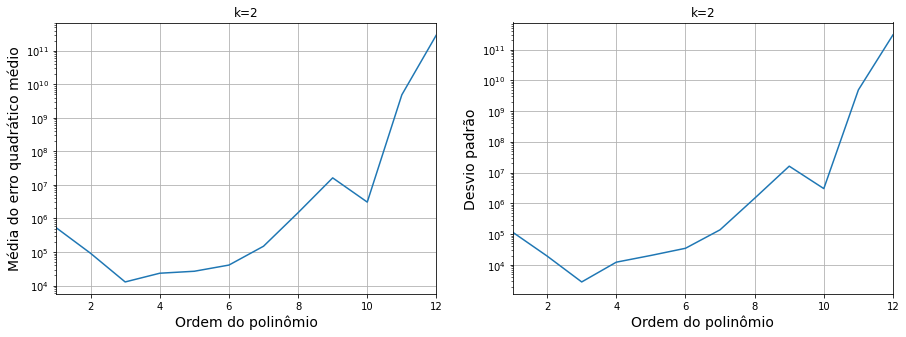

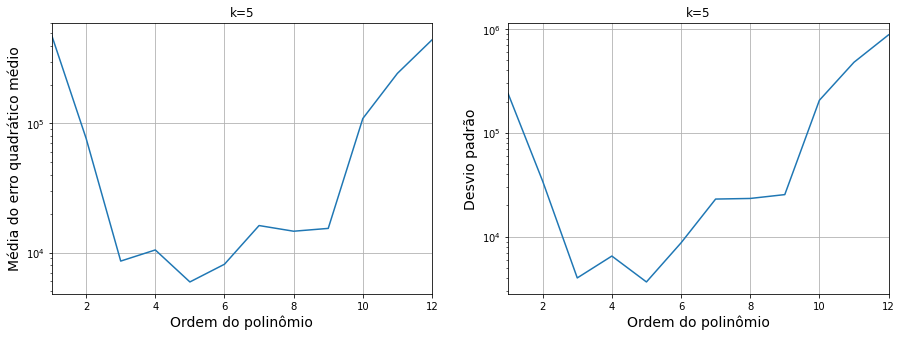

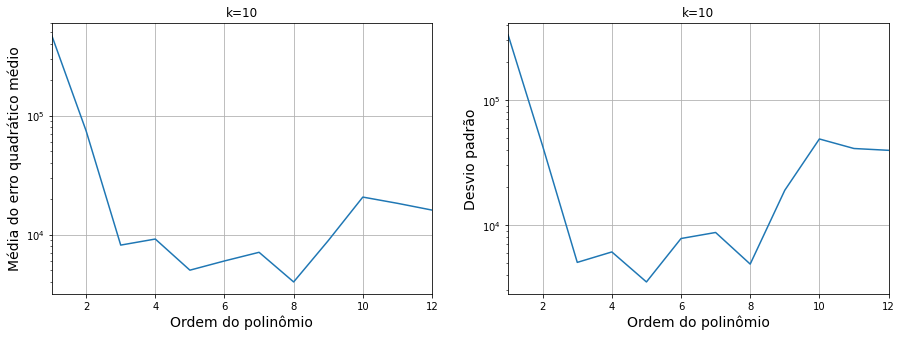

In [18]:
# Plot results.

for k in range(0, len(kSize)): 
    plt.figure(figsize=(15, 5))
    
    ax = plt.subplot(1, 2, 1)
    plt.plot(range(1, 13), mse_val_vec[k])
    plt.xlabel('Ordem do polinômio', fontsize=14)
    plt.ylabel('Média do erro quadrático médio', fontsize=14)
    plt.xticks(range(0, 13, 2))
    plt.xlim([1, 12])
    plt.title('k='+str(kSize[k]))
    plt.yscale('log')
    plt.grid()

    ax = plt.subplot(1, 2, 2)
    plt.plot(range(1, 13), std_val_vec[k])
    plt.xlabel('Ordem do polinômio', fontsize=14)
    plt.ylabel('Desvio padrão', fontsize=14)
    plt.xticks(range(0, 13, 2))
    plt.xlim([1, 12])
    plt.title('k='+str(kSize[k]))
    plt.yscale('log')
    plt.grid()

# Save figure
#plt.savefig("kfold.png", dpi=600)
#Show the plot.
plt.show()

   ## Leave-one-out cross-validation

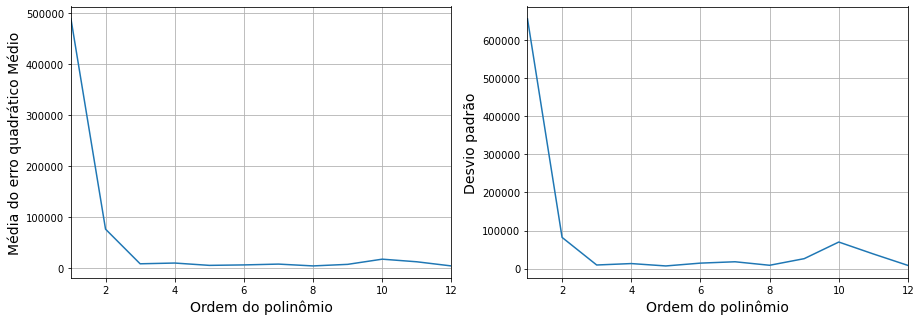

In [14]:
# Instantiate the LOOCV object.
loocv = LeaveOneOut()

mean_vec = []
std_vec = []
for d in range(1, 13):
    # Instantiate a polynomial.
    poly = PolynomialFeatures(degree=d, include_bias=include_bias)
    # Instantiate a scaler.
    scaler = StandardScaler()
    # Instantiate a linear regressor.
    reg = LinearRegression()

    # Create a pipeline of actions.
    poly_reg = Pipeline([
        ("poly", poly),
        ("scaler", scaler),
        ("reg", reg),
    ])

    lin_scores = cross_val_score(poly_reg, X, y, scoring='neg_mean_squared_error', cv=loocv)
        
    scores = -lin_scores
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    
# Plot results.
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec)
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()
plt.yscale('log')

ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec)
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()
plt.yscale('log')

#Show the plot.
plt.show()

## Learning-curves

In [19]:
degrees = [1, 3, 5, 10]

testSize = [0.1, 0.2, 0.3, 0.4]

numOfSeeds = 10

M = len(y)

mse_training = np.zeros((len(testSize), len(degrees), int(M*(1.0 - 0.1))+1 ))
mse_validation = np.zeros((len(testSize), len(degrees), int(M*(1.0 - 0.1))+1 ))

for t in range(0, len(testSize)):
    
    trainSize = int(M*(1.0 - testSize[t]))

    for i in range(0, len(degrees)):
        
        # Instantiate a polynomial.
        poly = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
        # Instantiate a scaler.
        scaler = StandardScaler()
        # Instantiate a linear regressor.
        reg = LinearRegression()

        # Create a pipeline of actions.
        poly_reg = Pipeline([
            ("poly", poly),
            ("scaler", scaler),
            ("reg", reg),
        ])
        
        for m in range(1, trainSize+1):                
                
            for s in range(0, numOfSeeds):     

                # Split the whole set into random training and validation set.
                x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=testSize[t], random_state=s)

                # Perform polynomial regression.
                poly_reg.fit(x_train[:m], y_train[:m])

                # Use the trained model for prediction of the training set.
                y_train_predict = poly_reg.predict(x_train[:m])

                # Use the trained model for prediction of the validation set.
                y_val_predict = poly_reg.predict(x_val)       

                # Calculate MSE for training set.
                mse_training[t][i][m-1] += mean_squared_error(y_train[:m], y_train_predict)

                # Calculate MSE for validation set.
                mse_validation[t][i][m-1] += mean_squared_error(y_val, y_val_predict)
            
            mse_training[t][i][m-1] /= numOfSeeds
            mse_validation[t][i][m-1] /= numOfSeeds

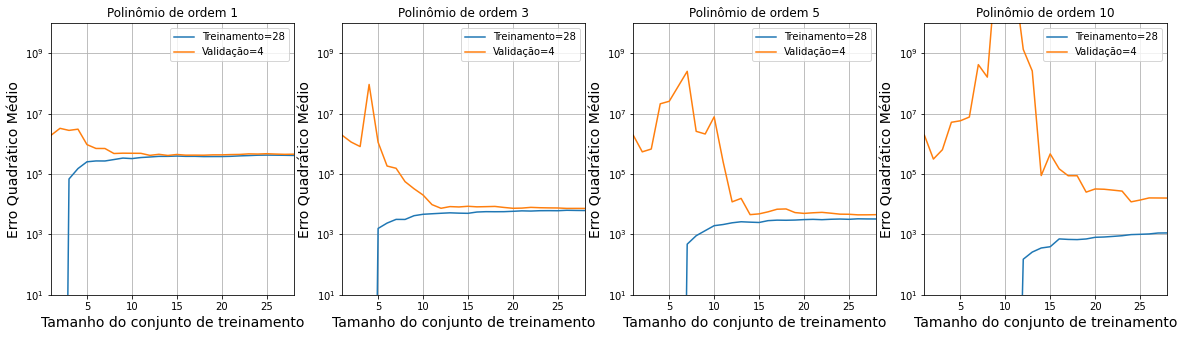

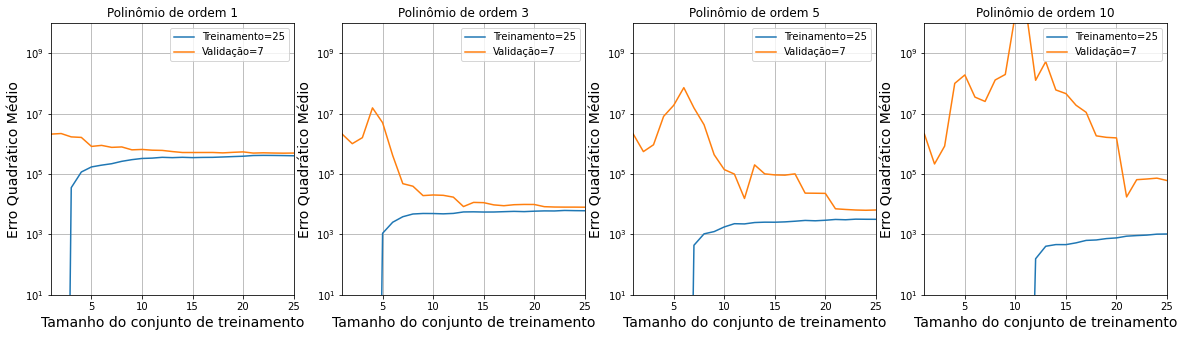

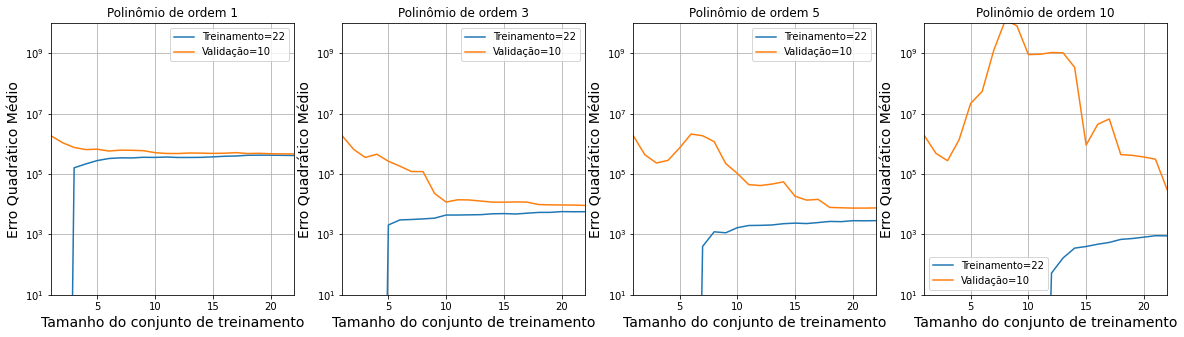

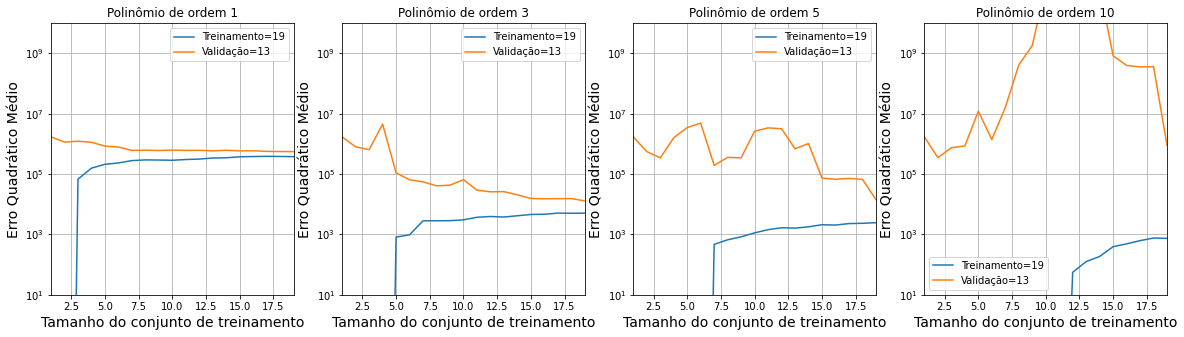

In [21]:
for t in range(0,len(testSize)):
    
    plt.figure(figsize=(20, 5))
    
    trainSize = int(M*(1.0 - testSize[t]))
    
    for i in range(0, len(degrees)):
        
        ax = plt.subplot(1, len(degrees), i + 1)
    
        plt.plot(range(1, trainSize+1), mse_training[t][i][0:trainSize], label='Treinamento='+str(trainSize))
        plt.plot(range(1, trainSize+1), mse_validation[t][i][0:trainSize], label='Validação='+str(M-trainSize))
        plt.yscale('log')
        plt.xlabel('Tamanho do conjunto de treinamento', fontsize=14)
        plt.ylabel('Erro Quadrático Médio', fontsize=14)
        plt.grid()
        plt.ylim([1e1, 1e10])
        plt.xlim([1, trainSize])
        plt.title('Polinômio de ordem '+str(degrees[i]))
        plt.legend(loc='best')
    
    # Show the plot.
    plt.show()

## Model training

In [23]:
degree = 3
include_bias = False

# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=degree, include_bias=include_bias)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a linear regressor.
reg = LinearRegression()

# Create a pipeline of actions.
model = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

# Train model.
model.fit(X, y)

# Perform prediction for 70 days.
X_pred = np.arange(1, 70).reshape(-1, 1)
y_pred = model.predict(X_pred)
X_pred = X_pred.reshape(1, -1)[0]

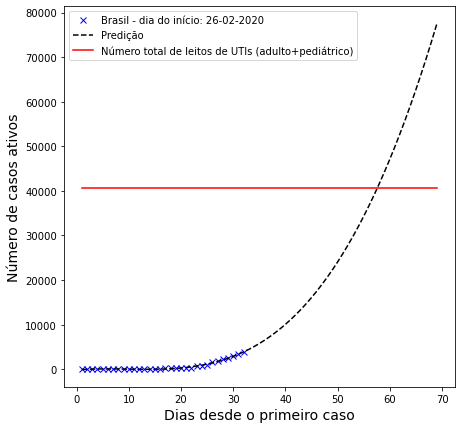

In [26]:
plt.figure(figsize=(7,7))
plt.plot(X,y,'bx',label='Brasil - dia do início: 26-02-2020')
plt.plot(X_pred,y_pred,'k--',label='Predição')
plt.plot(X_pred,40600*np.ones(len(X_pred)),'r',label='Número total de leitos de UTIs (adulto+pediátrico)')
plt.xlabel('Dias desde o primeiro caso', fontsize=14)
plt.ylabel('Número de casos ativos', fontsize=14)
plt.legend()
plt.show()

In [27]:
dia_ate_colapso_de_leitos = min([i+1 for i,v in enumerate(y_pred) if v >= 40600])
print('dia_ate_colapso_de_leitos: ', dia_ate_colapso_de_leitos)

dia_ate_colapso_de_leitos:  58
